## Load data

In [362]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [363]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [364]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

In [365]:
df_combined = pd.concat(dfs).sort_index()
# filter out 16 fps
df_combined = df_combined.drop(16, level='fps', axis=0)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8316 entries, (1, 10, 'False', 0) to (7, 20, 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           8316 non-null   object 
 1   status                             8316 non-null   object 
 2   infractions.collisions_layout      8316 non-null   object 
 3   infractions.collisions_pedestrian  8316 non-null   object 
 4   infractions.collisions_vehicle     8316 non-null   object 
 5   infractions.outside_route_lanes    8316 non-null   object 
 6   infractions.red_light              8316 non-null   object 
 7   infractions.route_dev              8316 non-null   object 
 8   infractions.route_timeout          8316 non-null   object 
 9   infractions.stop_infraction        8316 non-null   object 
 10  infractions.vehicle_blocked        8316 non-null   object 
 11  duration_game         

### Filter duplicated scenarios

In [366]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df_combined = df_combined.drop(excluded_routes, level='route_index', axis=0)


df_combined

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1   10  False       0              RouteScenario_0  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     301.100004       655.118260    350.831252        9.381381       0.335697    27.945936       0.093814
                    1              RouteScenario_1  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     251.100004       522.494851    289.985251       16.334576       0.326406    50.043754       0.163346
                    2              RouteScenario_2  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     228.100003       473.118934    272.631122       25.888396       0.572102    45.251365       0.258884
                    3              RouteScenario_3  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     128.100002       269.498117    153.049630       43.246647       0.976153    44.303132       0.432466
                    4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...  [Agent ran a red light 997 at (x=129.55, y=226...                    []          [Route timeout.]                          []                          []     190.100003       395.243434    218.597426       11.796465       0.648559    18.188726       0.117965
...                                            ...                       ...                           ...                               ...                                                ...                                                ...                                                ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
7   20  True      

## FPS factor, in high fidelity

In [367]:
df = df_combined.xs("True", level='highquality', drop_level=False)
df

route_id                      status                      infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction                        infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1   10  True        0              RouteScenario_0    Failed - Agent timed out  [Agent collided against object with type=stati...                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     301.100004       661.616342    350.831252       29.267785       0.416031    70.350080       0.292678
                    1              RouteScenario_1  Failed - Agent got blocked                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []                        []                          []  [Agent got blocked at (x=177.148, y=190.898, z...     190.400003       459.499749    289.985251        5.515321       0.726857     7.587907       0.055153
                    2              RouteScenario_2    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     228.100003       500.725377    272.631122       26.015119       0.943655    27.568479       0.260151
                    3              RouteScenario_3    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     128.100002       276.852260    153.049630       42.771830       0.965436    44.303132       0.427718
                    4              RouteScenario_4    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     190.100003       440.362709    218.597426       16.852092       0.884478    19.053149       0.168521
...                                            ...                         ...                                                ...                               ...                                                ...                                                ...                   ...                   ...                       ...                         ...                                       

In [368]:
# df = df.reset_index()
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    85.923624
18    86.373806
17    83.791449
15    80.297081
14    76.527102
12    60.108131
10    49.388818
Name: score_composed, dtype: float64

In [369]:
def plot(column: str, ax=None, col="b", marker='s'):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker=marker, color=col,)

    return axes

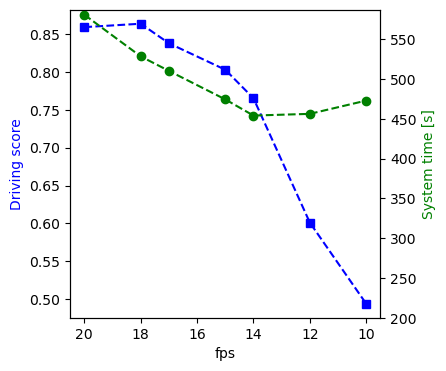

In [370]:
fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)
axes = plot("driving_score", axes)
axes.set_ylabel(f"Driving score", color='b')

axes = plot("duration_system", axes.twinx(), 'g', marker='o')
axes.set_ylabel(f"System time [s]", color='g')
axes.set_ylim(200)
axes.invert_xaxis()
fig.savefig('plot.pdf', bbox_inches='tight')
# fig

### Error bars

In [371]:
df.groupby(["rep"])["driving_score"].mean()

rep
1    0.743769
2    0.745008
3    0.747457
4    0.745712
5    0.745058
6    0.748941
7    0.748155
Name: driving_score, dtype: float64

#### ^ Pretty consitent repetitions

In [372]:
# mean across all scenarios
agg = df.groupby(["fps", "rep"])["driving_score"].mean()
agg

fps  rep
10   1      0.488241
     2      0.510286
     3      0.480487
     4      0.497056
     5      0.484445
     6      0.500599
     7      0.496103
12   1      0.597234
     2      0.594010
     3      0.614808
     4      0.598902
     5      0.598252
     6      0.616765
     7      0.587598
14   1      0.757078
     2      0.766914
     3      0.765494
     4      0.776476
     5      0.762085
     6      0.761684
     7      0.767166
15   1      0.800894
     2      0.787364
     3      0.800853
     4      0.811114
     5      0.803282
     6      0.806869
     7      0.810419
17   1      0.837657
     2      0.833776
     3      0.837975
     4      0.825665
     5      0.843516
     6      0.841202
     7      0.845610
18   1      0.867175
     2      0.862293
     3      0.872266
     4      0.860681
     5      0.865825
     6      0.852675
     7      0.865251
20   1      0.858102
     2      0.860412
     3      0.860320
     4      0.850090
     5      0.857999
    

In [373]:
agg.groupby("fps").min()
agg.groupby("fps").max()
agg.groupby("fps").mean()

fps
10    0.493888
12    0.601081
14    0.765271
15    0.802971
17    0.837914
18    0.863738
20    0.859236
Name: driving_score, dtype: float64

In [374]:
def plot_better(df, ax, column, style, err=True):
    agg = df.groupby(["fps", "rep"])[column].mean()
    mean = agg.groupby("fps").mean()

    range = np.vstack([np.abs(agg.groupby("fps").min()-mean),
                       np.abs(agg.groupby("fps").max()-mean)])

    yerr = range if err else None

    ax.errorbar(
        mean.index,
        mean,
        yerr=yerr,
        **style)
    return ax

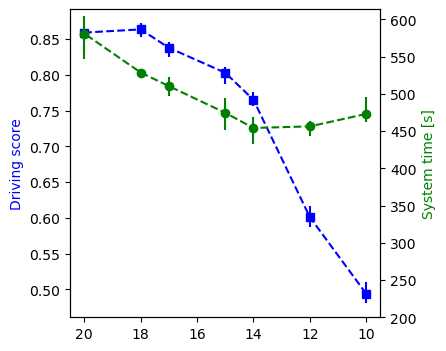

In [375]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')

style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "duration_system", style)
ax.set_ylabel(f"System time [s]", color='g')

ax.set_ylim(200)
ax.invert_xaxis()

#### ^ Error bars for driving score more consistent than system time

Normalize system time

### Normalize system time

In [376]:
oracle = df.xs(20, level='fps', drop_level=False).sort_index()

# oracle

In [377]:
# average time to perform each scenario
df['norm_sys_time'] = df['duration_system'] / \
    oracle.groupby('route_index')["duration_system"].mean()

/tmp/ipykernel_6527/4008945638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_sys_time'] = df['duration_system'] / \


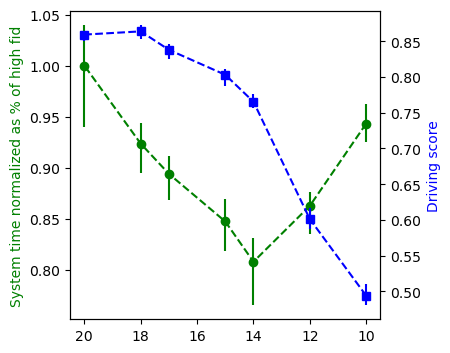

In [378]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax, "norm_sys_time", style)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax.twinx(), "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')


ax.invert_xaxis()

### Prediction error

In [379]:
oracle.groupby('route_index')['driving_score'].mean()

route_index
0      0.700000
1      0.927428
2      0.993872
3      1.000000
4      0.993208
5      1.000000
6      0.745714
7      0.900000
8      0.691218
9      1.000000
10     0.926959
11     1.000000
12     0.700000
13     1.000000
14     1.000000
15     1.000000
16     0.915525
17     0.993573
18     1.000000
19     0.925515
24     1.000000
25     0.998996
26     1.000000
27     0.443061
28     1.000000
29     0.534054
30     1.000000
31     0.647951
32     0.942857
33     1.000000
34     1.000000
35     1.000000
36     0.935149
37     1.000000
38     1.000000
39     0.885714
40     0.885714
41     1.000000
42     1.000000
43     0.520909
44     1.000000
45     0.453675
46     0.210482
47     1.000000
48     0.290577
49     0.753491
50     0.089538
51     1.000000
52     1.000000
53     1.000000
54     0.264374
55     0.533080
56     0.942857
57     0.852875
58     1.000000
59     1.000000
60     1.000000
61     0.568109
62     1.000000
63     1.000000
64     1.000000
65     0.851

In [380]:


df['square_error'] = (df['driving_score'] -
                      oracle.groupby('route_index')['driving_score'].mean()).pow(2).pow(1./2)

/tmp/ipykernel_6527/7081481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_error'] = (df['driving_score'] -


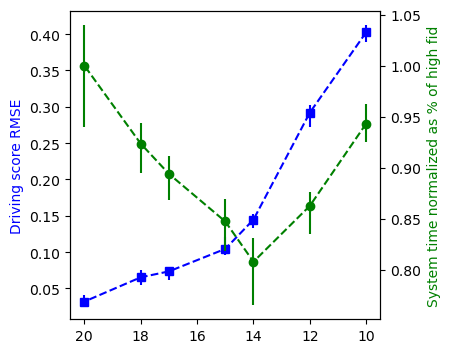

In [381]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "square_error", style)
ax.set_ylabel(f"Driving score RMSE", color='b')


style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "norm_sys_time", style,)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

ax.invert_xaxis()

## LOW/EPIC factor, in high fidelity

In [382]:
df10 = df_combined.xs(10, level='fps', axis=0, drop_level=False).sort_index()
df20 = df_combined.xs(20, level='fps', axis=0, drop_level=False).sort_index()

df = pd.concat([df10, df20]).sort_index()
df

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1   10  False       0              RouteScenario_0  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     301.100004       655.118260    350.831252        9.381381       0.335697    27.945936       0.093814
                    1              RouteScenario_1  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     251.100004       522.494851    289.985251       16.334576       0.326406    50.043754       0.163346
                    2              RouteScenario_2  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     228.100003       473.118934    272.631122       25.888396       0.572102    45.251365       0.258884
                    3              RouteScenario_3  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     128.100002       269.498117    153.049630       43.246647       0.976153    44.303132       0.432466
                    4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...  [Agent ran a red light 997 at (x=129.55, y=226...                    []          [Route timeout.]                          []                          []     190.100003       395.243434    218.597426       11.796465       0.648559    18.188726       0.117965
...                                            ...                       ...                           ...                               ...                                                ...                                                ...                                                ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
7   20  True      

In [383]:
df20['driving_score']

low_20 = df20.xs('False', axis=0, level='highquality')
epic_20 = df20.xs('True', axis=0, level='highquality')
# low_20
low_20

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   20  0              RouteScenario_0                 Completed                            []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []                        []                          []                          []     214.650003       658.604211    350.831252       98.098078       0.980981   100.000000       0.980981
        1              RouteScenario_1  Failed - Agent timed out                            []                                []                                                 []                                                 []                    []                    []          [Route timeout.]                          []                          []     251.050004       770.301058    289.985251       50.043754       1.000000    50.043754       0.500438
        2              RouteScenario_2                 Completed                            []                                []  [Agent collided against object with type=vehic...                                                 []                    []                    []                        []                          []                          []     165.000002       507.712214    272.631122       60.000000       0.600000   100.000000       0.600000
        3              RouteScenario_3                 Completed                            []                                []                                                 []                                                 []                    []                    []                        []                          []                          []      97.550001       299.391218    153.049630      100.000000       1.000000   100.000000       1.000000
        4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []                                                 []                    []                    []          [Route timeout.]                          []                          []     190.050003       588.518081    218.597426       81.414903       1.000000    81.414903       0.814149
...                                ...                       ...                           ...                               ...                                                ...                                                ...                   ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
7   20  127          RouteScenario_127                 Completed                            []                                []                                                 []                                                 []                    []                    []                        []                          []      

In [384]:
low20_list = low_20.groupby('route_index')['driving_score'].apply(list)
epic20_list = epic_20.groupby('route_index')['driving_score'].apply(list)

array([[<Axes: title={'center': '0'}>]], dtype=object)

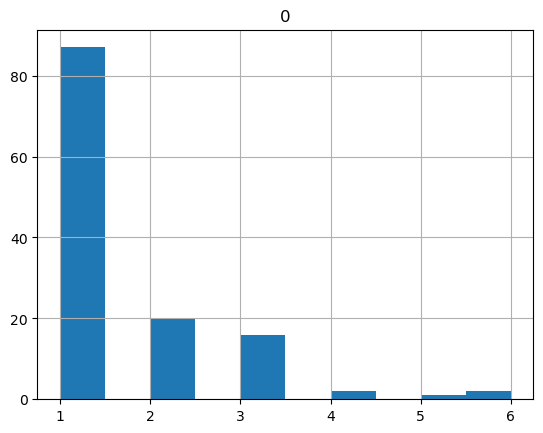

In [385]:
epic20_behaviours = {i: len(set(lst)) for i, lst in enumerate(epic20_list)}
low20_behaviours = {i: len(set(lst)) for i, lst in enumerate(low20_list)}

pd.DataFrame(epic20_behaviours.values(), index=epic20_behaviours.keys()).hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

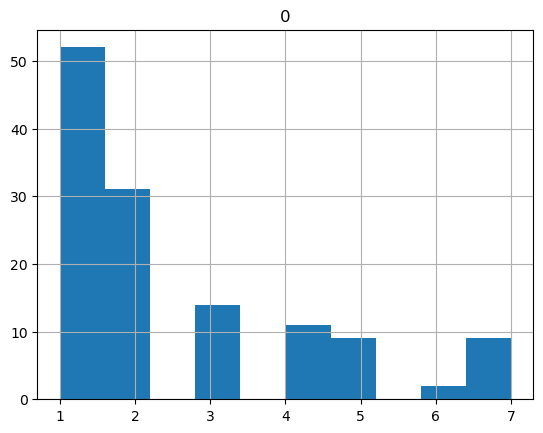

In [386]:
pd.DataFrame(low20_behaviours.values(), index=low20_behaviours.keys()).hist()

In [387]:
from scipy.stats import mannwhitneyu

diff = []
no_diff = []
for i, (epic, low) in enumerate(zip(epic20_list, low20_list)):
    U1, p = mannwhitneyu(epic, low, method="exact")

    confidence_level = 0.95
    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tThe difference for scenario: {i} is statistically significant. {p:.5f}")
        diff.append(i)
    else:
        print(
            f"\tThe difference for scenario: {i} is not statistically significant. {p:.5f}")
        no_diff.append(i)

	The difference for scenario: 0 is not statistically significant. 0.45571
	The difference for scenario: 1 is not statistically significant. 0.45571
	The difference for scenario: 2 is statistically significant. 0.03788
	The difference for scenario: 3 is not statistically significant. 1.00000
	The difference for scenario: 4 is statistically significant. 0.00058
	The difference for scenario: 5 is statistically significant. 0.00058
	The difference for scenario: 6 is not statistically significant. 1.00000
	The difference for scenario: 7 is not statistically significant. 0.09732
	The difference for scenario: 8 is not statistically significant. 0.71037
	The difference for scenario: 9 is not statistically significant. 0.45571
	The difference for scenario: 10 is not statistically significant. 0.05303
	The difference for scenario: 11 is not statistically significant. 1.00000
	The difference for scenario: 12 is statistically significant. 0.01748
	The difference for scenario: 13 is not statistical

In [389]:
print(
    f"For 128 scenarios there was a diffrence in {len(diff)} and no diffrence in {len(no_diff)}")
print(diff)
print(no_diff)

For 128 scenarios there was a diffrence in 29 and no diffrence in 99
[2, 4, 5, 12, 18, 25, 37, 40, 41, 42, 44, 46, 49, 53, 75, 79, 80, 81, 82, 83, 93, 102, 105, 107, 111, 115, 117, 122, 126]
[0, 1, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 43, 45, 47, 48, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 108, 109, 110, 112, 113, 114, 116, 118, 119, 120, 121, 123, 124, 125, 127]
